
# Lab Activity 4.3. Clustering Algorithms using sklearn (KMeans and MiniBatch KMeans)

We want to compare the performance of the MiniBatch KMeans and KMeans: the MiniBatchKMeans is faster, but gives slightly different results. We will cluster a dataset, first with KMeans and then with MiniBatchKMeans, and plot the results. We will also plot the points that are labelled differently between the two algorithms.

**Disclaimer.** This activity is adopted from [sklearn](https://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html).


**Learning Outcomes**
1. Implement a clustering solution using K-Means model from sklearn
2. Implement a clustering solution using mini-batch K-Means model from sklearn
3. Compare between the performances of both algorithms to appreciate their subtle differences


In [1]:
%matplotlib inline
from IPython.display import display, HTML
display(HTML('<style>.container {width: 85% !important}</style>'))

%set_env OMP_NUM_THREADS=1  
#to avoid a memory leak on windows with MiniBatchKMeans

env: OMP_NUM_THREADS=1


In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.datasets import make_blobs

## Generate sample data

In [3]:
np.random.seed(0)  # Set the random seed to ensure reproducibility of results.
batch_size = 45  # Define the batch size for data processing or clustering.
centers = [[1, 1], [-1, -1], [1, -1]]  # Specify the center points of the clusters.
n_clusters = len(centers)  # Calculate the number of clusters based on the number of center points.
X, labels_true = make_blobs(n_samples=3000, centers=centers, cluster_std=0.7)  
# Generate a dataset with 3000 samples distributed around the specified cluster centers.
# The clusters are created with a standard deviation of 0.7, and the true labels are also returned.

## Cluster the data using [K-means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans )

In [4]:
# Initialize the KMeans clustering algorithm with random initialization, 
# 3 clusters, and 10 random initializations to select the best model.
k_means = KMeans(init='random', n_clusters=3, n_init=10)

# Record the current time to measure how long the model fitting process takes.
t0 = time.time()

# Fit the KMeans model to the data (X).
k_means.fit(X)

# Calculate the time taken to fit the KMeans model.
t_batch = time.time() - t0

## Clustering the data using [MiniBatchKMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html#sklearn.cluster.MiniBatchKMeans )

In [5]:
# Initialize the MiniBatchKMeans model with specific parameters:
# 'init': Method for initialization, using 'k-means++' for better centroids initialization.
# 'n_clusters': Number of clusters to form (3 in this case).
# 'batch_size': Number of samples in each batch for mini-batch updates.
# 'n_init': Number of times the algorithm will run with different centroid seeds.
# 'max_no_improvement': Early stopping if no improvement in inertia is observed after 10 iterations.
# 'verbose': Verbosity level (0 means no output).
mbk = MiniBatchKMeans(init='k-means++', n_clusters=3, batch_size=batch_size,
                      n_init=10, max_no_improvement=10, verbose=0)

# Record the current time before fitting the model for performance measurement.
t0 = time.time()

# Fit the MiniBatchKMeans model to the dataset X.
mbk.fit(X)

# Calculate the total time taken to fit the MiniBatchKMeans model.
t_mini_batch = time.time() - t0

## Plot the results

In [6]:
### helper functions

# Function to plot clustered points and their cluster center
def clust_plot(points, center):
    # Plot the points in the cluster using a small circular marker
    ax.plot(X[points, 0], X[points, 1], 'o', markersize=4, markerfacecolor=col)
    # Plot the cluster center using a larger plus marker with a black edge
    ax.plot(center[0], center[1], '+', markersize=16, markerfacecolor=col, markeredgecolor='k')

# Function to configure the plot's appearance and display additional details
def set_fig(title, time, inertia):
    # Set the title of the plot
    ax.set_title(title)
    # Remove x-axis and y-axis tick marks for a cleaner plot
    ax.set_xticks(())
    ax.set_yticks(())
    # Add text to the plot showing training time and inertia value
    plt.text(-3.5, 1.8, 'train time: %.2fs\ninertia: %f' % (time, inertia))

Plot K-means and mini batch K-means and the differences between them in three subplots.


[ True False False ... False False False]
[False  True  True ...  True  True  True]


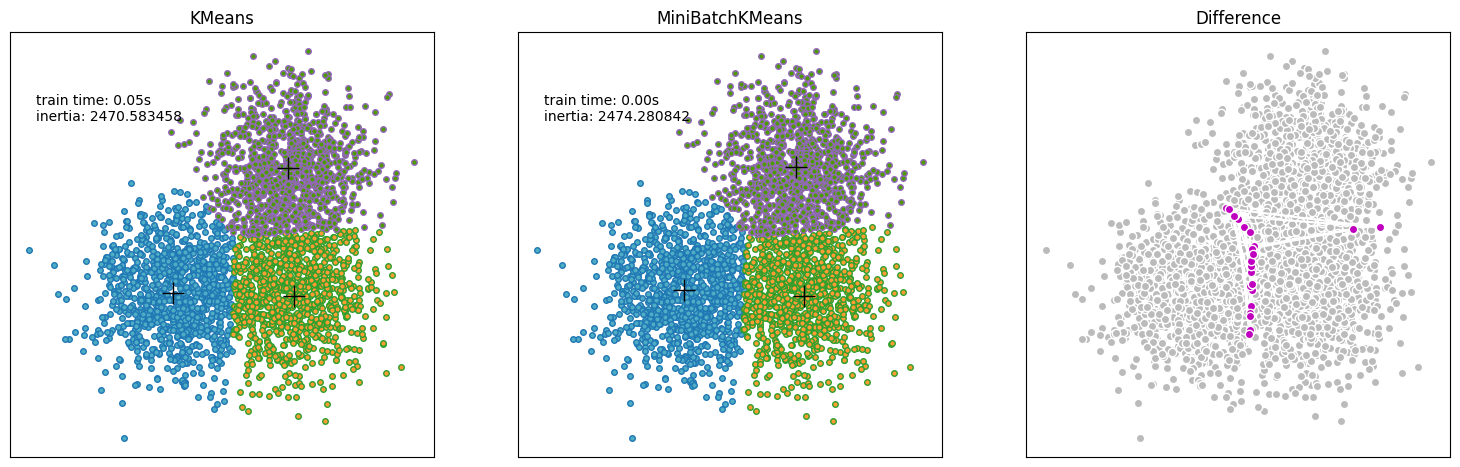

In [7]:
# Create a figure object with specified size
fig = plt.figure(figsize=(15, 5))
# Adjust the spacing and margins of the subplots
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
# Define a list of colors to represent clusters
colors = ['#4EACC5', '#FF9C34', '#4E9A06']

# Match colors for clusters between MiniBatchKMeans and KMeans by pairing cluster centers
k_centers = k_means.cluster_centers_  # Get the cluster centers for KMeans
# Find the closest MiniBatchKMeans centers to the KMeans centers
order = pairwise_distances_argmin(k_means.cluster_centers_, mbk.cluster_centers_)
# Reorder the MiniBatchKMeans cluster centers to align with KMeans clusters
mbk_centers = mbk.cluster_centers_[order]

# Assign data points to the closest KMeans cluster center
k_labels = pairwise_distances_argmin(X, k_centers)
# Assign data points to the closest MiniBatchKMeans cluster center
mbk_labels = pairwise_distances_argmin(X, mbk_centers)

# KMeans clustering results visualization ----------------------------------------------------
ax = fig.add_subplot(1, 3, 1)  # Add the first subplot to the figure
# Iterate over each cluster and corresponding color
for k, col in zip(range(n_clusters), colors):
    clust_points = k_labels == k  # Identify points belonging to cluster k
    clust_center = k_centers[k]  # Get the center of cluster k
    clust_plot(clust_points, clust_center)  # Plot the points and center for the cluster

# Add a title and inertia value to the subplot for KMeans
set_fig('KMeans', t_batch, k_means.inertia_)  # Inertia measures clustering quality

# MiniBatchKMeans clustering results visualization -------------------------------------------
ax = fig.add_subplot(1, 3, 2)  # Add the second subplot to the figure
# Iterate over each cluster and corresponding color
for k, col in zip(range(n_clusters), colors):
    clust_points = mbk_labels == k  # Identify points belonging to cluster k
    clust_center = mbk_centers[k]  # Get the center of cluster k
    clust_plot(clust_points, clust_center)  # Plot the points and center for the cluster

# Add a title and inertia value to the subplot for MiniBatchKMeans
set_fig('MiniBatchKMeans', t_mini_batch, mbk.inertia_)

# Initialize a Boolean array to track differences between KMeans and MiniBatchKMeans clusters ----
different = (mbk_labels == 4)  # Start with a condition that will be updated

# Add the third subplot to visualize the differences between clustering results
ax = fig.add_subplot(1, 3, 3)
# Compare cluster assignments for each cluster
for k in range(n_clusters):
    # Update the "different" array where cluster assignments are not identical
    different += ((k_labels == k) != (mbk_labels == k))

# Create an array of points where the cluster assignments are identical
identic = np.logical_not(different)

# Print the "different" and "identic" arrays for debugging
print(different)
print(identic)

# Plot points where cluster assignments are identical (in gray)
ax.plot(X[identic, 0], X[identic, 1], 'w', markerfacecolor='#bbbbbb', marker='.', markersize=12)
# Plot points where cluster assignments differ (in magenta)
ax.plot(X[different, 0], X[different, 1], 'w', markerfacecolor='m', marker='.', markersize=12)

# Add a title and remove axis ticks for the "Difference" subplot
ax.set_title('Difference')
ax.set_xticks(())
ax.set_yticks(())

# Display the entire plot with all subplots
plt.show()